In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [2]:
import gym
from gym import spaces
import random
from collections import deque, defaultdict

In [3]:
# Load the dataset
file_path1 = "datasets/v2/v2_datasets-corrigido/dataset_normal.csv"
file_path2 = "datasets/v2/v2_datasets-corrigido/dataset_poisoned.csv"

In [4]:
data1 = pd.read_csv(file_path1)
data2 = pd.read_csv(file_path2)

In [5]:
def preprocess_data(df):
    # Convert 'Weapon Detected' to binary (1 for 'Yes', 0 for 'No')
    #df['Weapon Detected'] = df['Weapon Detected'].apply(lambda x: 1 if x == 'Yes' else 0)

    # Encode 'Timestamp' using LabelEncoder
    label_encoder = LabelEncoder()
    df['Hour'] = label_encoder.fit_transform(df['Hour'])
    
    week_label = LabelEncoder()
    df['Weekday/Weekend'] = week_label.fit_transform(df['Weekday/Weekend'])

    # Extract state and action data
    state_data = df[['Hour', 'Presence Detector', 'Face Recognition', 'Weapon Recognition']].values
    actions = df['Action'].values
    
    return state_data, actions

In [6]:
# Preprocess the dataset
state_data_N, actions_N = preprocess_data(data1)

In [7]:
state_data_N

array([[  0,   0,   0,   0],
       [  1,   0,   0,   0],
       [  2,   0,   0,   0],
       ...,
       [141,   1,   4,   0],
       [142,   1,   4,   0],
       [143,   1,   4,   0]])

In [8]:
actions_N

array([0, 0, 0, ..., 0, 0, 0])

In [9]:
# Preprocess the dataset
state_data_P, actions_P = preprocess_data(data2)

In [10]:
state_data_P

array([[  0,   0,   0,   0],
       [  1,   0,   0,   0],
       [  2,   0,   0,   0],
       ...,
       [141,   1,   4,   0],
       [142,   1,   4,   0],
       [143,   1,   4,   0]])

In [11]:
class RealTimeEnvironment(gym.Env):
    def __init__(self, state_data_N, actions_N, state_data_P, actions_P):
        super(RealTimeEnvironment, self).__init__()
        self.state_data_N = state_data_N
        self.actions_data_N = actions_N
        self.state_data_P = state_data_P
        self.actions_data_P = actions_P
        self.current_step = 0

        # Define observation space (4 features: Timestamp, Presence Sensor, Persons Recognized, Weapon Detected)
        self.observation_space = spaces.Box(low=0, high=1, shape=(4,), dtype=np.float32)
        
        # Action space: 2 actions (0: do nothing, 2: inform owner and police)
        self.action_space = spaces.Discrete(2)
        
    def reset_N(self):
        self.current_step = 0
        return self.state_data_N[self.current_step]
    
    def reset_P(self):
        self.current_step = 0
        return self.state_data_P[self.current_step]

    def step_N(self, action):
        correct_action = self.actions_data_N[self.current_step]
        reward = 1 if (action * 2) == correct_action else -1
        
        # Move to the next step
        self.current_step += 1
        done = self.current_step >= len(self.state_data_N)
        
        # Get the next state
        if not done:
            next_state = self.state_data_N[self.current_step]
        else:
            next_state = np.zeros(self.state_data_N.shape[1])
        
        return next_state, reward, done, {}
    
    def step_P(self, action):
        correct_action = self.actions_data_P[self.current_step]
        reward = 1 if (action * 2) == correct_action else -1
        
        # Move to the next step
        self.current_step += 1
        done = self.current_step >= len(self.state_data_P)
        
        # Get the next state
        if not done:
            next_state = self.state_data_P[self.current_step]
        else:
            next_state = np.zeros(self.state_data_P.shape[1])
        
        return next_state, reward, done, {}
    
    def render_N(self):
        print(f"Step: {self.current_step}, State: {self.state_data_N[self.current_step]}")
        
    def render_P(self):
        print(f"Step: {self.current_step}, State: {self.state_data_P[self.current_step]}")

In [12]:
# Q-Learning parameters
learning_rate = 0.1
discount_factor = 0.99
exploration_rate = 1.0
exploration_decay = 0.995
exploration_min = 0.01
total_episodes = 1000  # Number of episodes for training
state_discretizer = (10, 2, 2, 2)  # Tuple representing discrete bins for each state feature

In [13]:
# Initialize the environment
env = RealTimeEnvironment(state_data_N, actions_N, state_data_P, actions_P)

In [14]:
# Initialize Q-table using a defaultdict for easy default values
q_table = defaultdict(lambda: [0, 0])  # Two actions, initialized to zero

In [15]:
q_table

defaultdict(<function __main__.<lambda>()>, {})

In [16]:
# Helper function to discretize continuous states
def discretize_state(state):
    """Convert continuous state into a discrete tuple."""
    return tuple(int(state[i] // (1 / state_discretizer[i])) for i in range(len(state)))

In [17]:
# Metrics for tracking performance
reward_history = deque(maxlen=2016)
action_accuracy = deque(maxlen=2016)

In [18]:
# Continuous Q-learning training loop
poison = False
avg_reward = []
suc_rate = []
for episode in range(total_episodes):
    state = env.reset_N() if poison == False else env.reset_P()
    state = discretize_state(state)
    done = False
    episode_reward = 0

    while not done:
        # Epsilon-greedy action selection
        if random.uniform(0, 1) < exploration_rate:
            action = env.action_space.sample()  # Explore
        else:
            action = np.argmax(q_table[state])  # Exploit the best known action
        
        # Take the action in the environment
        next_state, reward, done, _ = env.step_N(action) if poison == False else env.step_P(action)
        next_state = discretize_state(next_state)
        
        # Update Q-value using Q-learning formula
        best_future_q = max(q_table[next_state]) if not done else 0
        q_table[state][action] += learning_rate * (reward + discount_factor * best_future_q - q_table[state][action])
        
        # Update state and metrics
        state = next_state
        episode_reward += reward
        action_accuracy.append(1 if reward == 1 else 0)  # Track if action was correct
        
    # Track episode reward
    reward_history.append(episode_reward)

    # Decay exploration rate
    exploration_rate = max(exploration_min, exploration_rate * exploration_decay)
    
    if episode >= 20:
        poison = True
    
    # Output training progress
    if episode % 10 == 0:
        average_reward = np.mean(reward_history)
        success_rate = np.mean(action_accuracy)
        avg_reward.append(average_reward)
        suc_rate.append(success_rate)
        print(f"Episode {episode}: Avg Reward = {average_reward:.2f}, Success Rate = {success_rate:.2f}")

Episode 0: Avg Reward = -126.00, Success Rate = 0.47
Episode 10: Avg Reward = -19.45, Success Rate = 0.52
Episode 20: Avg Reward = 13.81, Success Rate = 0.51
Episode 30: Avg Reward = 82.26, Success Rate = 0.58
Episode 40: Avg Reward = 140.88, Success Rate = 0.58
Episode 50: Avg Reward = 190.27, Success Rate = 0.60
Episode 60: Avg Reward = 242.26, Success Rate = 0.65
Episode 70: Avg Reward = 287.04, Success Rate = 0.65
Episode 80: Avg Reward = 328.15, Success Rate = 0.66
Episode 90: Avg Reward = 366.31, Success Rate = 0.68
Episode 100: Avg Reward = 404.38, Success Rate = 0.70
Episode 110: Avg Reward = 440.97, Success Rate = 0.72
Episode 120: Avg Reward = 476.17, Success Rate = 0.72
Episode 130: Avg Reward = 510.92, Success Rate = 0.74
Episode 140: Avg Reward = 546.64, Success Rate = 0.75
Episode 150: Avg Reward = 578.33, Success Rate = 0.76
Episode 160: Avg Reward = 609.76, Success Rate = 0.78
Episode 170: Avg Reward = 640.09, Success Rate = 0.79
Episode 180: Avg Reward = 669.96, Succes

In [20]:
import matplotlib.pyplot as plt

In [22]:
episodes = [x for x in range(0,1000,10)]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


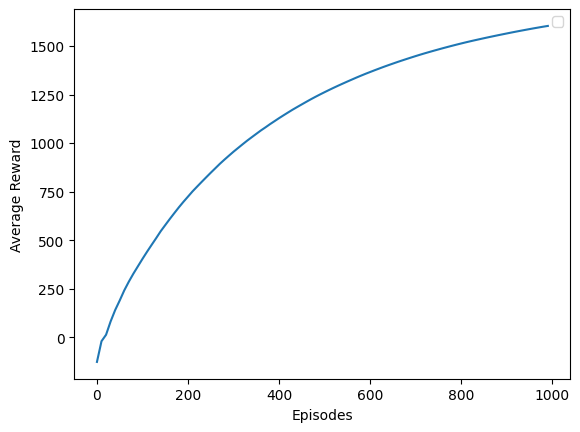

In [23]:
plt.plot(episodes,avg_reward)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.legend()
plt.savefig("Avg_poison.png")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


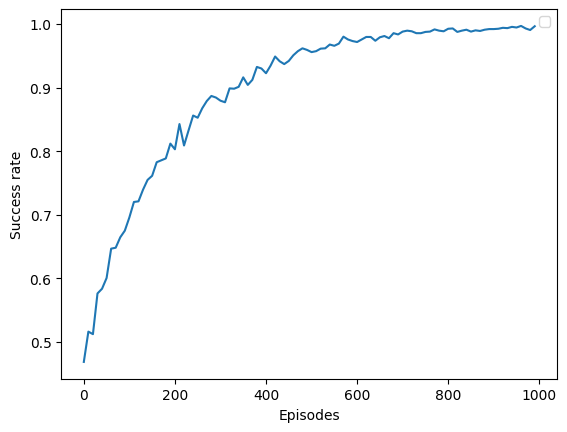

In [24]:
plt.plot(episodes,suc_rate)
plt.xlabel('Episodes')
plt.ylabel('Success rate')
plt.legend()
plt.savefig("suc_poison.png")